In [115]:
import pandas as pd
import stan as ps
import numpy as np
import matplotlib.pyplot as plt

# Importing nest_asyncio is only necessary to run pystan in Jupyter Notebooks.
import nest_asyncio
nest_asyncio.apply()


# Causal inference, Synthetic Control and Sales analysis

The follwing example is an application of Casual analysis for marketing data. The data here has been dowloaded from the open source github repo of 1749 https://github.com/nialloulton/1749/blob/main/CausalPy/CausalPy%20Synthetic%20Control.ipynb check out his great blog posts at https://1749.io/resource-center/f/quantifying-retail-media-impact-with-causalpy-causal-inference?blogcategory=Marketing. 1749 use the real cool Causalpy API to demosntrate this type of analyis. However, this path  hides much of the detail and udnrstning for analyst and also how this method can be so useful. This were this notebook is great addition using the Stan PPL to complete the Bayesian analysis. This will help the reader/analyst to get a firmer grasp on the statistical model/methodology and ultimatley the value of synthetic control for real world marketing analysis problems.

The data below is simulated sales data for a set of Samsung products (Pixel and galaxy range) phones, laptops etc. The data spans a 2 year period (2021/2023).  In the simulated data the products are simulated to come on to the market in a staggered fashion in the year of 2021. The reason for such detail in the simulation prodcuced by 1749 is that this reflects reality and allows for Causal thinking of how to model the data and generate more accurate inferences about the data and therfore on marketing sales.

In [116]:
#Url for github where dataset the is stored
url = 'https://raw.githubusercontent.com/HPCurtis/Datasets/main/1749.csv'
full_df = pd.read_csv(url)

# Convert the 'Date' column to datetime format
# Convert the 'Date' column to datetime format
full_df['Date'] = pd.to_datetime(full_df['Date'])

# Filter out only the Pixelophone_XL data and other control products data
pixelophone_xl_data = full_df[full_df['Product'] == 'Pixelophone_XL'].set_index('Date')
other_products_data = full_df[full_df['Product'] != 'Pixelophone_XL'].pivot(index='Date', columns='Product', values='Sales')

other_products_data

# Combine the two DataFrames
combined_data = pd.concat([pixelophone_xl_data['Sales'], other_products_data], axis=1).fillna(0)
combined_data.shape
# # Rename the 'Sales' column to 'Pixelophone_XL'
combined_data = combined_data.rename(columns={'Sales': 'Pixelophone_XL'})

y = combined_data['Pixelophone_XL'].values
X =combined_data.loc[:, combined_data.columns != 'Pixelophone_XL'].values

In [117]:
combined_data['Pixelophone_XL']

Date
2021-02-10    0.0
2021-02-11    0.0
2021-02-12    0.0
2021-02-13    0.0
2021-02-14    0.0
             ... 
2023-12-22    0.0
2023-12-23    0.0
2023-12-24    0.0
2023-12-25    0.0
2023-12-26    0.0
Freq: D, Name: Pixelophone_XL, Length: 1050, dtype: float64

(0.0, 2500.0)

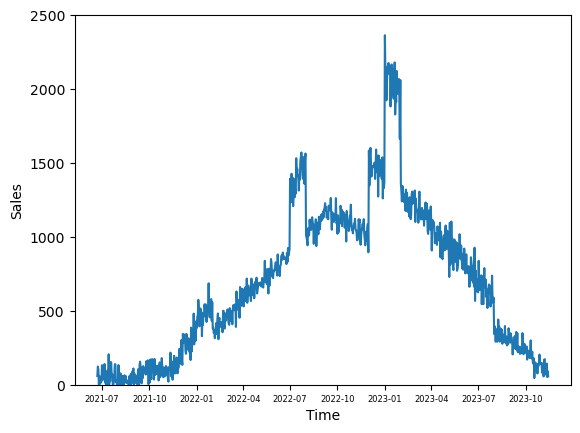

In [118]:
plt.plot(PixXL.Date, PixXL.Sales);
plt.xticks(fontsize = 6);
plt.xlabel('Time');
plt.ylabel('Sales');
plt.ylim(0, 2500)

# Stan model for Sythentic contol

The following model is a Stan implementation of the CausalPy model (see, https://github.com/pymc-labs/CausalPy/blob/main/causalpy/pymc_models.py)). 

$$ \sim Normal(\mu,15)

\mu \sim Normal(100, 20)
$$

In [127]:
stanSynthticControl = ''' 
data{
int N;
int K;
array[N] real y;
matrix[N,K] X;

// Priro value for sd of sigma parameter
real sdS;

}
parameters{
simplex[K] beta;
real<lower = 0> sigma; 
}

transformed parameters{
vector[N] mu;
mu = X * beta;
}

model{
// Priors 
sigma ~ normal(0, sdS);
// Uniform default prior
beta ~ dirichlet( rep_vector(1, K) );

// Likelihood
y ~ normal(mu, sigma);
}

generated quantities{
array[N] real yrep;
yrep = normal_rng(mu, sigma);
}
'''


In [128]:
data = {'N': len(y),
        'K': X.shape[1],
        'y': y,
        'X':X,
        'sdS': 5
        }

sm = ps.build(stanSynthticControl,data= data)

Building...

In file included from /home/harrison/anaconda3/envs/pystan_env/lib/python3.11/site-packages/httpstan/include/stan/math/prim/functor.hpp:12,
                 from /home/harrison/anaconda3/envs/pystan_env/lib/python3.11/site-packages/httpstan/include/stan/math/rev/fun.hpp:198,
                 from /home/harrison/anaconda3/envs/pystan_env/lib/python3.11/site-packages/httpstan/include/stan/math/rev.hpp:10,
                 from /home/harrison/anaconda3/envs/pystan_env/lib/python3.11/site-packages/httpstan/include/stan/math.hpp:19,
                 from /home/harrison/anaconda3/envs/pystan_env/lib/python3.11/site-packages/httpstan/include/stan/model/model_header.hpp:4,
                 from /home/harrison/.cache/httpstan/4.6.1/models/ayu6zdmt/model_ayu6zdmt.cpp:2:
/home/harrison/anaconda3/envs/pystan_env/lib/python3.11/site-packages/httpstan/include/stan/math/prim/functor/hcubature.hpp: In function 'void stan::math::internal::combination(std::vector<int>&, const int&, const int&, const int


Building: 25.0s, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.


In [129]:
fit = sm.sample()

Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   9% (703/8000)
Sampling:  10% (802/8000)
Sampling:  35% (2801/8000)
Sampling:  60% (4800/8000)
Sampling:  76% (6100/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 8.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.87 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000152 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.52 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000167 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.67 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.56 seconds.
  Adjust your expectations accordi